# Ajuste de los parámetros de un modelo a datos "toy"
### Este notebook está organizado de la siguiente forma: 
1. Definición de modelos de señal y fondo para generar nuestros "toys"
2. Visualización de los datos
3. Ajuste de los parámetros minimizando el $\chi^{2}$ entre el modelo y los datos. 
4. Profundizando en el proceso de minimización

Creamos lienzos sobre los que mostrar los plots

In [1]:
%jsroot on // To activate the interactive display of the histograms we can use the JSROOT magic

In [2]:
#include<TFile.h>
#include<TH1.h>
#include<TMath.h>
#include<math.h>
#include<TF1.h>
#include<TLine.h>
#include<TPoint.h>
#include<iostream>
#include<string>
#include<stdio.h>

In [3]:
TCanvas *cModels = new TCanvas("cModels","cModels",900, 600); //este lo usaremos para los modelos
cModels->Divide(3,1); //lo dividimos en una red the 3x1
TCanvas *cToys = new TCanvas("cToys","cToys",900, 600); //este lo usaremos para los modelos
cToys->Divide(2,1); //lo dividimos en una red the 3x1
TCanvas *c1 = new TCanvas("c1","c1",900, 600); //este es comodin, por si queremos dibujar algo
gStyle->SetPalette(1); //opcional: cambia la paleta de colores en los plots. 

## Modelos de señal y fondo y "toys"
El modelo que vamos a construir está "inspirado" en el descubrimiento del boson de Higgs en su canal de desintegración difotón:
- La forma de la señal es descrita por una distribución Gaussiana. 
- La forma del fondo es descrita por una distribución exponencial. 
El número de eventos totales se podría expresar de la siguiente forma: 
$ N_{total} = N_{sig}\times PDF_{sig} + N_{bkg}\times PDF_{bkg} = N_{total} \left(f_{sig}\times PDF_{sig} +(1-f_{sig})\times PDF_{bkg}\right)$
donde:
- $N_{total,sig,bkg}$ son el número de eventos totales, de señal y de fondo respectivamente. 
- $PDF_{sig}$ y $PDF_{bkg}$ son las funciones de densidad de probabilidad de la señal y fondo respectivamente. 
- $f_{sig}$ es la fracción de eventos de señal con respecto al número de eventos totales $\left(=N_{sig}/(N_{sig}+N_{bkg})=N_{sig}/N_{total}\right)$

Primero, definimos las variables y parámetros que necesitamos: 

In [4]:
Float_t fSig = 0.05;
Int_t nEntries = 10000;
Float_t minVal = 100.000; 
Float_t maxVal = 160.000;

Cada componente del modelo (señal o fondo) va a ser definido como una PDF en el intervalo definido arriba (minVal,maxVal). 

Como hemos dicho, la señal está descrita por una distribución gaussiana, centrada en un valor de masa 'mass' y con una anchura 'sigma'. 
En este caso tenemos herramientas que normalizan automáticamente la distribución. 

In [5]:
//PDF de la señal, más info: https://root.cern.ch/root/html524/TMath.html#TMath:Gaus
signalModel = new TF1("signalModel","TMath::Gaus(x,[0],[1],1)",minVal,maxVal);
signalModel->SetParNames("mass","sigma"); //nombres de los parámetros
signalModel->SetParameters(125,5.35); //valores de los parámetros
signalModel->FixParameter(0,123.8);
cModels->cd(1);
signalModel->Draw();

El fondo, descrito por una exponencial, require una normalización explícita.
Nosotros hoy la vamos a hacer utilizando directamente la integral de la función calculada de forma numérica. 
Sin embargo, en este caso tiene solución análitica (es un buen ejercicio, comprobad que la sabéis obtener...)

In [6]:
//PDF del fondo, una exponencial
bkgModel = new TF1("bkgModel","TMath::Exp(-(x-[1])/[0])",minVal,maxVal);
bkgModel->SetParameters(50,100);
normBkg = 1./bkgModel->Integral(minVal,maxVal);
cout << "Integral fondo en el rango utilizado: " << bkgModel->Integral(minVal,maxVal) << endl;
cout << "1/Integral fondo en el rango utilizado: " << normBkg << endl;
bkgModel = new TF1("bkgModel","0.0286203*TMath::Exp(-(x-[1])/[0])", minVal, maxVal); //////////// preguntar
bkgModel->SetParNames("tau","delta");
bkgModel->SetParameters(50,100);
//bkgModel->FixParameter(2,normBkg);
cModels->cd(2);
bkgModel->Draw();

Integral fondo en el rango utilizado: 34.9403
1/Integral fondo en el rango utilizado: 0.0286203


Ahora, combinamos ambas PDF en una sola, incluyendo la cantidad de eventos de señal y fondo. 

In [7]:
fullModel = new TF1("fullModel","(signalModel*[0]+[1]*bkgModel)",minVal,maxVal);
fullModel->SetParName(0,"nsig");
fullModel->SetParName(1,"nbkg");
fullModel->SetParameter("nsig",nEntries*fSig);
fullModel->SetParameter("nbkg",nEntries*(1-fSig));
fullModel->FixParameter(2,100);
fullModel->Print("v");
cModels->cd(3);
fullModel->Draw();

Formula based function:     fullModel 
            fullModel : (signalModel*[0]+[1]*bkgModel) Ndim= 1, Npar= 6, Number= 0 
 Formula expression: 
	((TMath::Gaus(x,[mass],[sigma],1))*[nsig]+[nbkg]*(0.0286203*TMath::Exp(-(x-[delta])/[tau]))) 
List of  Variables: 
Var   0                    x =    0.000000 
List of  Parameters: 
Par   0                 nsig =  500.000000 
Par   1                 nbkg =  9500.000000 
Par   2                delta =  100.000000 
Par   3                 mass =  123.800000 
Par   4                sigma =    5.350000 
Par   5                  tau =   50.000000 
Expression passed to Cling:
	#pragma cling optimize(2)
Double_t TFormula____id10358610802336685641(Double_t *x,Double_t *p){ return ((TMath::Gaus(x[0],p[3],p[4],1))*p[0]+p[1]*(0.0286203*TMath::Exp(-(x[0]-p[2])/p[5]))) ; }


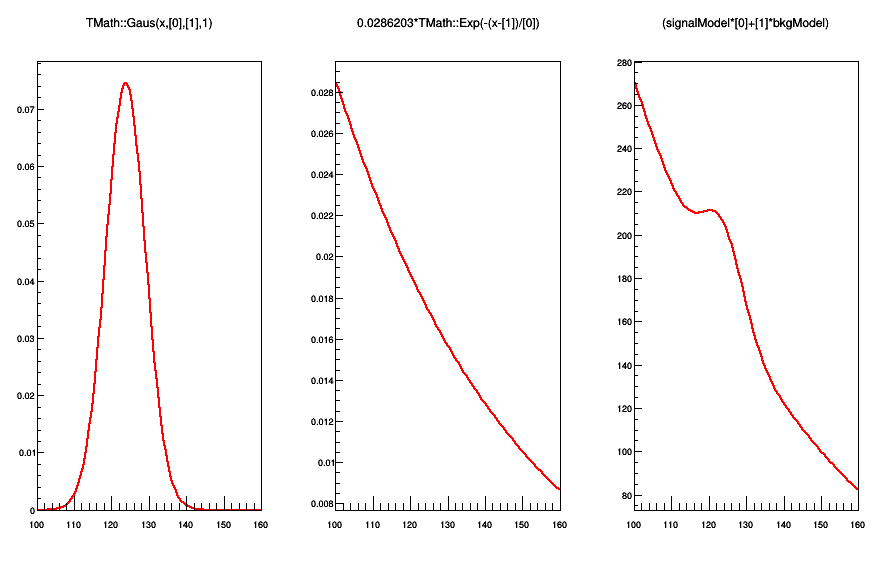

In [8]:
cModels->Draw();

## Generar toys a partir de un modelo
El modelo expuesto anteriormente sirve de base para generar "datos", que vamos a utilizar para el ajuste de los parámetros. 
Los toys se generan utilizando un generador de números aleatorios de ROOT.
La siguiente celda genera entonces los toys de señal y fondo y los dibuja. 

Input signal events: 537


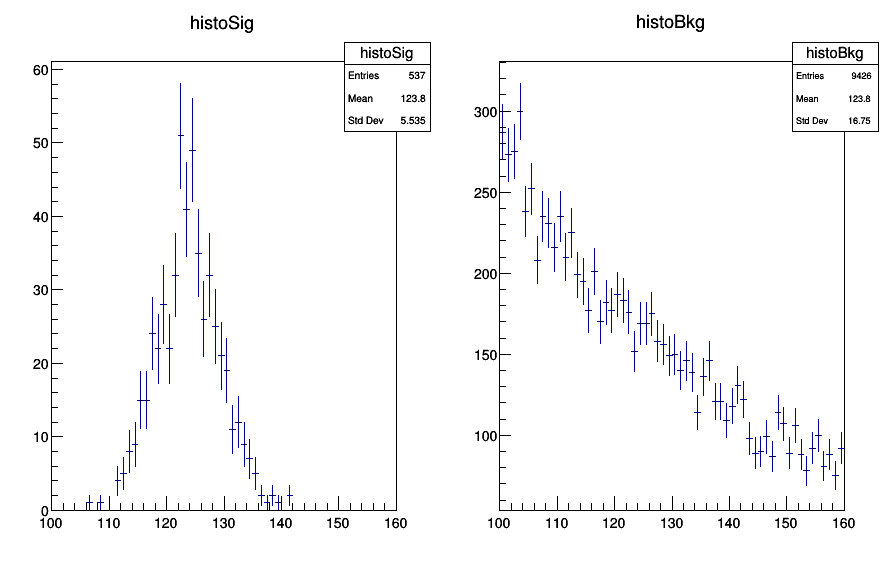

In [9]:
const Int_t nbins = 60;
gRandom->SetSeed(100); //importante fijar una semilla para la reproducibilidad de resultados. 
toySignal = gRandom->Poisson(nEntries*fSig); //el número de eventos señal y fondo lo obtenemos del valor de nuestro modelo y le permitimos que fluctue de forma Poissoniana. 
toyBkg = gRandom->Poisson(nEntries*(1-fSig));
cout << "Input signal events: " << toySignal << endl;
histoBkg = new TH1D("histoBkg","histoBkg",nbins, minVal,maxVal);
histoSig = new TH1D("histoSig","histoSig",nbins, minVal,maxVal);
histoBkg->FillRandom("bkgModel",toyBkg);
histoSig->FillRandom("signalModel",toySignal);
cToys->cd(1);
histoSig->Draw("e");
cToys->cd(2);
histoBkg->Draw("e");
cToys->Draw();

Y ahora, los combinamos y hacemos el ajuste de los parámetros.

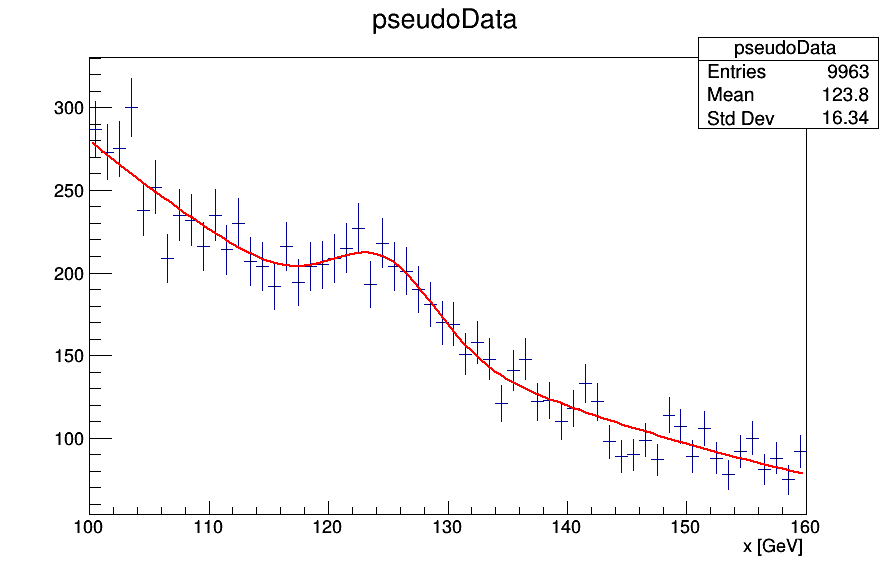

Minval: 26.865


In [10]:
c1->cd();
//stack = THStack("stack","stack");
//histoBkg->SetFillColor(2);
//histoSig->SetFillColor(4);
//stack->Add(histoBkg);
//stack->Add(histoSig);
pseudoData =  new TH1D("pseudoData","pseudoData",nbins, minVal,maxVal);
pseudoData->GetXaxis()->SetTitle("x [GeV]");
// pseudoData->GetYaxis()->SetTitle("Entries / {} GeV".format((maxVal-minVal)/nbins)); /////////////Preguntar
pseudoData->Add(histoBkg);
pseudoData->Add(histoSig);
pseudoData->Draw("e");
fullModel->SetParameters(nEntries*fSig,nEntries*(1-fSig),100.000000,125.000000,2.400000 ,50);
for (Int_t i=0; i<6; i++) { fullModel->ReleaseParameter(i); }
//fullModel->FixParameter(2,100);
//pseudoData->Fit("fullModel","L");
//pseudoData->Fit("fullModel");

//r = pseudoData.Fit("fullModel",  "LQS", "", minVal, maxVal); // L: likelihood, Q: quiet, reduce printing, S: save fit result
r = pseudoData->Fit("fullModel",  "LQS", "", minVal, maxVal); // L: likelihood, Q: quiet, reduce printing, S: save fit result 
cout << "Minval: " << r->MinFcnValue() << endl ;

//stack->Draw("same")
c1->Draw();

## ¿Qué estamos haciendo realmente?
En la parte anterior hemos obtenido una esimación de los parámetros y sus errores a través de una minimización del $\chi^{2}$ (en realidad no hemos sido nosotros, ROOT lo ha hecho utilizando un software que se llama MINUIT, y cuyo contenido sale un poco de la línea del curso..).

<h1><center>$\chi^{2} = \sum \frac{(x_{data}-x_{model})^{2}}{\sigma_{data}^{2}}$</center></h1>

Grosso modo: en el hiperespacio de parámetros libres (en nuestro caso, 5) ha generado una hipersuperficie de $\chi^{2}$. Lógicamente, cada conjunto de parámetros tiene un $\chi^{2}$
calculado el gradiente de la superficie en cada punto, y apuntado al punto en el cual es mínimo. 
Para "verlo" mejor, vamos a hacer una simplificación: vamos a fijarnos exclusivamente en dos parámetros (la masa y la anchura de la señal) y vamos a ver qué cara tiene dicha superficie en ese subespacio de dos parámetros. 

Primero creamos un histograma bidimensional

In [11]:
Float_t stepMass = 0.5;
Float_t stepWidth = 0.25;
binMass = int((maxVal-minVal)/stepMass);
binWidth = int(10./stepWidth);
chi2dPlot = new TH2D("chi2dPlot","chi2dPlot",binMass,minVal-stepMass/2.0,maxVal-stepMass/2.0,binWidth,0.5,10.5);

cout << "binMass: " << binMass << endl;
cout << "binWidth: " << binWidth << endl;

binMass: 120
binWidth: 40


Luego realizamos ajustes fijando tanto la masa como la anchura, de forma que nos permitan obtener el $\chi^{2}$ en función de dichos parámetros. Sin fijarlos, obtendríamos siempre el valor que más se ajuste a los datos (en el mínimo!).  

In [12]:
//this is for the chi2 on the mass and width
chi2dPlot->Clear();
for (Float_t masses = minVal; masses < maxVal; masses+=stepMass){
    //cout << "Filling: externo mass: "<< masses << ". bin:" << chi2dPlot->GetXaxis()->FindBin(masses) << endl;
    for (double widths = 0.25; widths < 10.5; widths+=stepWidth){
        //cout << "Filling: interno mass and bin: " << widths << chi2dPlot->GetYaxis()->FindBin(widths) << endl;
        fullModel->SetParameters(nEntries*fSig,nEntries*(1-fSig),100.000000,125.000000,2.400000 ,50);
        fullModel->FixParameter(3,masses);
        fullModel->FixParameter(4,widths);
        pseudoData->Fit("fullModel","QL");
        chi2dPlot->SetBinContent(chi2dPlot->FindBin(masses,widths),fullModel->GetChisquare());
    }
}

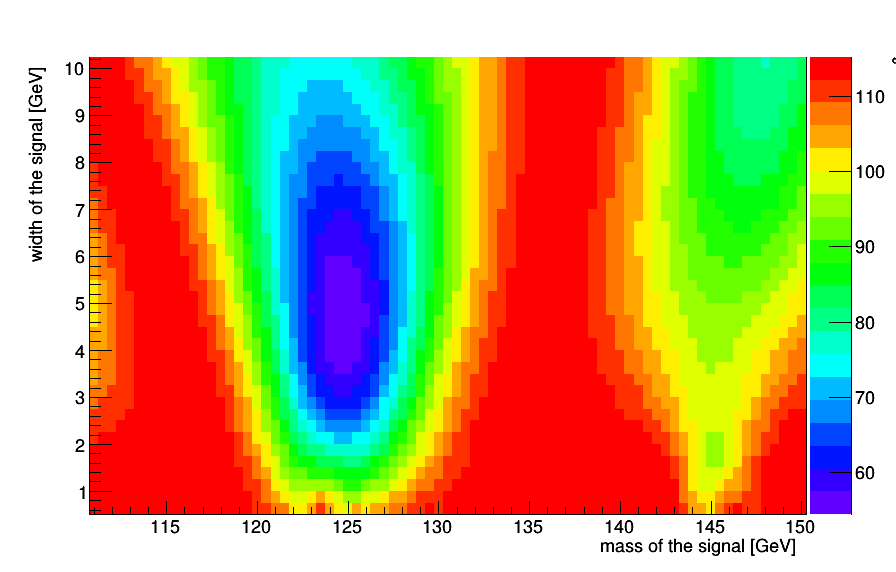

In [13]:
//remove borders..
chi2dPlot->SetAxisRange(0.5,10,"y");
chi2dPlot->SetAxisRange(111,150,"x");
chi2dPlot->GetXaxis()->SetTitle("mass of the signal [GeV]");
chi2dPlot->GetYaxis()->SetTitle("width of the signal [GeV]");
chi2dPlot->GetZaxis()->SetTitle("#chi^{2}");
chi2dPlot->Draw("colz");
gStyle->SetOptStat(000000);
c1->Draw();

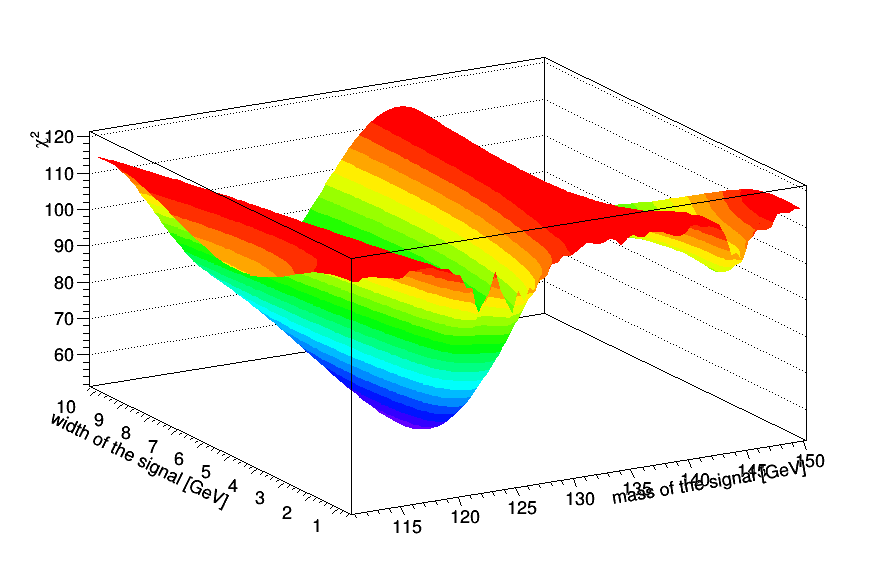

In [14]:
// remove borders..
chi2dPlot->SetAxisRange(0.5,10,"y");
chi2dPlot->SetAxisRange(111,150,"x");
chi2dPlot->GetXaxis()->SetTitle("mass of the signal [GeV]");
chi2dPlot->GetYaxis()->SetTitle("width of the signal [GeV]");
chi2dPlot->GetZaxis()->SetTitle("#chi^{2}");
chi2dPlot->Draw("surf2");
gStyle->SetOptStat(000000);
c1->Draw();